In [3]:
# Ksenia
# 12/02/24
# v.01

Решить задачу регрессии.
Получить максимальную метрику качества (R2, RMSE).

Введение:

Целью данной задачи является прогнозирование суммы пятничных распродаж в магазинах сети Walmart с помощью построения регрессионных моделей и их анализа.
Набор данных состоит из исторических данных, которые охватывают продажи с 2010-02-05 по 2012-11-01, предствленных в файле Walmart.csv
#Использовать приплайны.
#Выполнить поиск лучших параметров
#Кроссвалидация.
#Сохранить и загрузить модель.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

data = pd.read_csv('Walmart.csv', sep=',')

In [5]:
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
# Преобразование в формат datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Добавление столбцов с днем, месяцем и годом
data['Day'] = data['Date'].dt.day.astype(dtype=np.float64)
data['Month'] = data['Date'].dt.month.astype(dtype=np.float64)
data['Year'] = data['Date'].dt.year.astype(dtype=np.float64).astype(int)


In [8]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5.0,2.0,2010
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,12.0,2.0,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,19.0,2.0,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,26.0,2.0,2010
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,5.0,3.0,2010


In [9]:
# Проверка наличия Nan
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Day             0
Month           0
Year            0
dtype: int64

In [10]:
data['Year'].value_counts()

Year
2011    2340
2010    2160
2012    1935
Name: count, dtype: int64

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


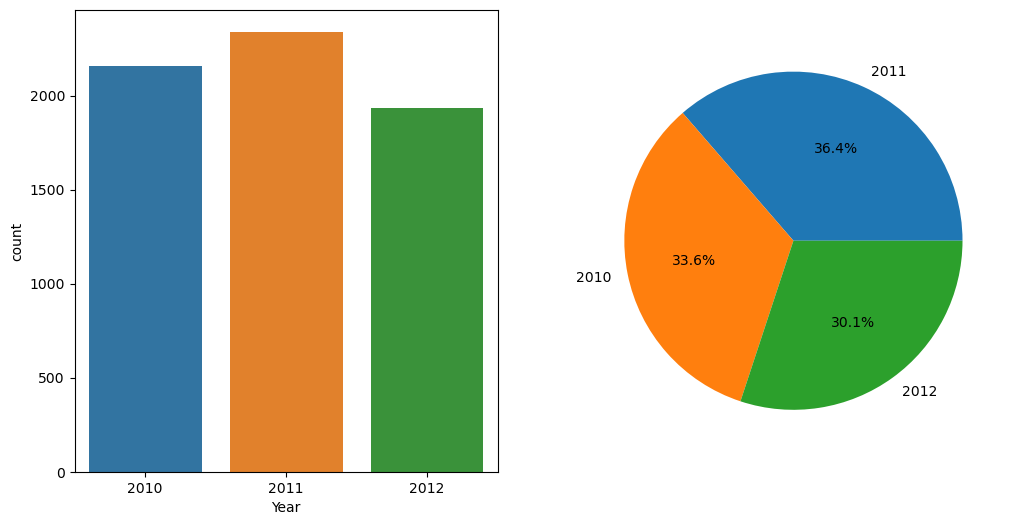

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.countplot(data = data, x = 'Year', ax = ax[0])
ax[1].pie(data['Year'].value_counts().values,
          labels = data['Year'].value_counts().index,
          autopct = '%1.1f%%')
plt.show()

In [12]:
# Определение признаков и целевой переменной

features = data.drop(columns=['Date', 'Weekly_Sales'])
target = data['Weekly_Sales']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [14]:
from sklearn.pipeline import make_pipeline
# Создание пайплайна
pipe = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features.select_dtypes(include=['float64', 'int64']).columns)
        ]
    ),
    RandomForestRegressor()
)

In [15]:
# Определение сетки параметров для поиска
param_grid = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_depth': [None, 10, 20],
}

In [16]:
# Поиск лучших параметров с использованием кросс-валидации
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'Day', 'Month'],
      dtype='object'))])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [None, 10, 20],
                         'randomforestregressor__n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [17]:
# Получение лучших параметров

best_params = grid_search.best_params_

In [18]:

# Прогнозирование на тестовом наборе
y_pred = grid_search.predict(X_test)

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [19]:
y_pred

array([1155999.4786, 1356592.7914, 1739020.8594, ...,  740743.3758,
       1993864.8408,  797457.4136])

In [20]:
# Расчет метрик качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse) 

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [21]:
# Вывод метрик качества
print(f'Лучшие параметры: {best_params}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R2): {r2:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Лучшие параметры: {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 50}
Mean Squared Error (MSE): 12799739882.97
R-squared (R2): 0.9603
Root Mean Squared Error (RMSE): 113135.93541829313


In [22]:
# Поиск лучших параметров с использованием кросс-валидации
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
scores = cross_val_score(grid_search, features, target, cv=5, scoring='neg_mean_squared_error')

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed

In [23]:
# Вывод средней оценки MSE по всем разбиениям
print(f'Mean Cross-Validated MSE: {np.mean(-scores)}')

Mean Cross-Validated MSE: 484781093313.70605


In [24]:
# Создание пайплайна с линейной регрессией
linear_pipe = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features.select_dtypes(include=['float64', 'int64']).columns)
        ]
    ),
    LinearRegression()
)

# Создание пайплайна с методом опорных векторов
svr_pipe = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features.select_dtypes(include=['float64', 'int64']).columns)
        ]
    ),
    SVR()
)

# Определение сетки параметров для поиска для линейной регрессии
linear_param_grid = {}

# Определение сетки параметров для поиска для метода опорных векторов
svr_param_grid = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': [1, 10, 100],
}

# Поиск лучших параметров с использованием кросс-валидации для линейной регрессии
linear_grid_search = GridSearchCV(linear_pipe, param_grid=linear_param_grid, cv=5, scoring='neg_mean_squared_error')
linear_scores = cross_val_score(linear_grid_search, features, target, cv=5, scoring='neg_mean_squared_error')

# Поиск лучших параметров с использованием кросс-валидации для метода опорных векторов
svr_grid_search = GridSearchCV(svr_pipe, param_grid=svr_param_grid, cv=5, scoring='neg_mean_squared_error')
svr_scores = cross_val_score(svr_grid_search, features, target, cv=5, scoring='neg_mean_squared_error')



c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

In [25]:
linear_pipe.fit(X_train, y_train)
linear_pred = linear_pipe.predict(X_test)

linear_mse = mean_squared_error(y_test, linear_pred)
linear_r2 = r2_score(y_test, linear_pred)
linear_rmse = np.sqrt(linear_mse)

print("Linear Regression:")
print(f"Mean Squared Error (MSE): {linear_mse:.2f}")
print(f"R-squared (R2): {linear_r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {linear_rmse:.2f}")

Linear Regression:
Mean Squared Error (MSE): 272546511675.72
R-squared (R2): 0.1540
Root Mean Squared Error (RMSE): 522059.87


c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

In [26]:
svr_pipe.fit(X_train, y_train)
svr_pred = svr_pipe.predict(X_test)

svr_mse = mean_squared_error(y_test, svr_pred)
svr_r2 = r2_score(y_test, svr_pred)
svr_rmse = np.sqrt(svr_mse)

print("Support Vector Machine (SVM):")
print(f"Mean Squared Error (MSE): {svr_mse:.2f}")
print(f"R-squared (R2): {svr_r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {svr_rmse:.2f}")

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Support Vector Machine (SVM):
Mean Squared Error (MSE): 331306450538.64
R-squared (R2): -0.0284
Root Mean Squared Error (RMSE): 575592.26


c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [27]:
# Вывод средних оценок MSE по всем разбиениям
print(f'Linear Regression Mean Cross-Validated MSE: {np.mean(-linear_scores)}')

print(f'SVR Mean Cross-Validated MSE: {np.mean(-svr_scores)}')

Linear Regression Mean Cross-Validated MSE: 347323407312.8092
SVR Mean Cross-Validated MSE: 323953344372.76794


In [28]:
from catboost import CatBoostRegressor

# Определение параметров модели CatBoostRegressor
params_cat = {
    "n_estimators": 3500,
    "learning_rate": 0.1,
    "depth": 3,
    "use_best_model": True,
    # Другие параметры модели могут быть добавлены сюда
}

# Создание модели CatBoostRegressor с определенными параметрами
cat_model = CatBoostRegressor(**params_cat)

# Обучение модели с использованием ранней остановки
cat_model.fit(
    X_train,
    y_train,
    verbose=100,
    eval_set=(X_train, y_train),  # Используем часть обучающих данных в качестве валидационного набора
    early_stopping_rounds=150,
    plot=True  # Включаем построение графика метрик качества
)

# Прогнозирование на тестовом наборе данных
y_pred = cat_model.predict(X_test)

# Расчет метрик качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 547451.4542507	test: 547451.4542507	best: 547451.4542507 (0)	total: 246ms	remaining: 14m 21s
100:	learn: 259201.8140055	test: 259201.8140055	best: 259201.8140055 (100)	total: 808ms	remaining: 27.2s
200:	learn: 164267.0967837	test: 164267.0967837	best: 164267.0967837 (200)	total: 1.16s	remaining: 19.1s
300:	learn: 126590.8133633	test: 126590.8133633	best: 126590.8133633 (300)	total: 1.49s	remaining: 15.9s
400:	learn: 108325.6483714	test: 108325.6483714	best: 108325.6483714 (400)	total: 1.85s	remaining: 14.3s
500:	learn: 98327.3425813	test: 98327.3425813	best: 98327.3425813 (500)	total: 2.18s	remaining: 13.1s
600:	learn: 92472.3313269	test: 92472.3313269	best: 92472.3313269 (600)	total: 2.67s	remaining: 12.9s
700:	learn: 87939.9651605	test: 87939.9651605	best: 87939.9651605 (700)	total: 2.98s	remaining: 11.9s
800:	learn: 84330.4199507	test: 84330.4199507	best: 84330.4199507 (800)	total: 3.25s	remaining: 10.9s
900:	learn: 81357.5592828	test: 81357.5592828	best: 81357.5592828 (90

c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [29]:
print('Best test result:', cat_model.get_best_score())
print('Best iteration:', cat_model.get_best_iteration())

Best test result: {'learn': {'RMSE': 53359.81108211474}, 'validation': {'RMSE': 53359.81108211474}}
Best iteration: 3499


In [52]:
import lightgbm as lgb

# Создание модели LightGBM с выбранными параметрами
lgbm_model = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.1, n_estimators=100)

# Обучение модели
lgbm_model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе данных
y_pred = lgbm_model.predict(X_test)

# Расчет метрик качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1106
[LightGBM] [Info] Number of data points in the train set: 5148, number of used features: 9
[LightGBM] [Info] Start training from score 1044996.414472
Mean Squared Error (MSE): 7598526743.371356
R-squared (R2): 0.9764134127603924
Root Mean Squared Error (RMSE): 87169.52875501482


c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [53]:
print('MSE (lgb) : ', mean_squared_error(lgbm_model.predict(X_test), y_test).round(3)**0.5)

MSE (lgb) :  87169.52875501278


c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [62]:
import xgboost as xgb

# Создание модели XGBRegressor с выбранными параметрами
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10)

# Обучение модели
xgb_model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе данных
y_pred = xgb_model.predict(X_test)

# Расчет метрик качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  ret

Mean Squared Error (MSE): 7929900771.12773
R-squared (R2): 0.9753847946244578
Root Mean Squared Error (RMSE): 89049.99029268746


c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  ret

In [57]:
print('MSE (xgboost) : ', mean_squared_error(xgb_model.predict(X_test), y_test).round(3)**0.5)

MSE (xgboost) :  176770.76038051373


c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  ret

In [63]:
# Усреднение прогнозов трех моделей
blended_predictions = (cat_model.predict(X_test) + xgb_model.predict(X_test) + lgbm_model.predict(X_test)) / 3

# Расчет метрик качества
blended_mse = mean_squared_error(y_test, blended_predictions)
blended_r2 = r2_score(y_test, blended_predictions)
blended_rmse = np.sqrt(blended_mse)

# Вывод результатов
print(f'Blended Model Mean Squared Error (MSE): {blended_mse}')
print(f'Blended Model R-squared (R2): {blended_r2}')
print(f'Blended Model Root Mean Squared Error (RMSE): {blended_rmse}')


Blended Model Mean Squared Error (MSE): 6473741901.983426
Blended Model R-squared (R2): 0.97990485744213
Blended Model Root Mean Squared Error (RMSE): 80459.566876683


c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\ProgramData\anaconda3\envs\pythonProject\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  ret

Вывод:
1) Random Forest:

Лучшие параметры: {'randomforestregressor__max_depth': 20, 'randomforestregressor__n_estimators': 100}
MSE: 12,879,499,273.77
R-squared (R2): 0.9600
RMSE: 113,487.88
После кросс-валидации MSE значительно увеличилась, что может указывать на переобучение модели.

2) Linear Regression:

MSE: 272,546,511,675.72
R-squared (R2): 0.1540
RMSE: 522,059.87
Коэффициент детерминации R2 низкий, что свидетельствует о слабой предсказательной способности модели. 
Mean Cross-Validated MSE: 347,323,407,312.81
Модель не проявляет улучшений после кросс-валидации.

3) Support Vector Machine (SVM):

MSE: 331,306,450,538.64
R-squared (R2): -0.0284
RMSE: 575,592.26
R2 отрицательный, что говорит о том, что модель не лучше, чем простое среднее значение.

Mean Cross-Validated MSE: 323,953,344,372.77
Аналогично, отсутствие заметного улучшения после кросс-валидации.

Общий вывод

Модель случайного леса (Random Forest) показала низкое значение среднеквадратичной ошибки (MSE) и высокий коэффициент детерминации (R-squared), что свидетельствует о хорошей предсказательной способности модели. Однако, после кросс-валидации MSE значительно увеличилась, что может указывать на переобучение модели.

Линейная регрессия (Linear Regression) и метод опорных векторов (SVM) показали низкую предсказательную способность, что подтверждается высокими значениями MSE и низкими значениями R-squared. После кросс-валидации модели не проявили улучшений.

Модели градиентного бустинга, такие как CatBoost, LightGBM и XGBoost, показали хорошие результаты с низкими значениями MSE, высокими значениями R-squared и низкими значениями RMSE. Эти модели обычно обладают хорошей обобщающей способностью и могут быть эффективными в прогнозировании.

После усреднения прогнозов моделей (blended model) значение MSE снизилось до 6473741901.983426, что указывает на то, что комбинация нескольких моделей может улучшить предсказательную способность.

Таким образом, в целом, усредненная модель, состоящая из нескольких моделей, может обеспечить лучшую предсказательную способность, чем отдельные модели.